# (3 of 3) DT RF
---
# Churn Prediction of bank customers

# Decision Tree, Random Forest
---

In [1]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

from sklearn.metrics import confusion_matrix, \
accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('./dataset/Churn_Modelling.csv')

In [4]:
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

#### Drop rows that values exceeded lower/upper fences

In [5]:
def my_func(feature, upper, lower):
    tmp = df[(df[feature] >= upper) | (df[feature] <= lower)]
    print('Dropping', tmp.shape[0], 'of', df.shape[0], 'rows.')
    df.drop(index=tmp.index, inplace=True)

In [6]:
my_func('CreditScore',None,383)
my_func('Age',59,None)
#my_func('Balance',198e3,41e3)

Dropping 16 of 10000 rows.
Dropping 587 of 9984 rows.


#### Create dummy variables

In [7]:
df_new = pd.get_dummies(df, drop_first=True)

#### Train-Test Split with the 80:20 ratio

In [8]:
X = df_new.drop('Exited', axis=1)
y = df_new['Exited']

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

#### This evaluation function will keep the evaluation values to use in the Performance Graph Comparison later.

In [11]:
df_model_compare = pd.read_csv('./eval_results/eval_results.csv',index_col=0)

In [12]:
acc = df_model_compare.loc['Accuracy'].to_dict()
f1 = df_model_compare.loc['F1 Score'].to_dict()
prec = df_model_compare.loc['Precision'].to_dict()
recl = df_model_compare.loc['Recall'].to_dict()

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    display(df_model_compare)

**For this dataset:**

**Recall** value is more important. If we predict churn (from the total churn customers) more correctly, the bank will have to attract the right customers before they churn.

To reduce errors, **False Negative** is more important since it tells us that the customers won't churn, but the truth is they churn. If we predict wrong, the bank won't attract the right customers, and they may churn.

---
# 5. Decision Tree
---

Tree-based algorithms are not quite sensitive to data scale, so it's unnecessary to perform Data Scaling.

In [13]:
from sklearn.tree import DecisionTreeClassifier

### Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
parameters = {
    'max_depth':[4,8,12,16,32,64,128],
    'min_samples_leaf':[1,2,4,8,16,24,32,40,64]
}

In [16]:
grid_search = GridSearchCV(DecisionTreeClassifier(),
                           parameters, verbose=1, scoring='f1')

In [17]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 8, 12, 16, 32, 64, 128],
                         'min_samples_leaf': [1, 2, 4, 8, 16, 24, 32, 40, 64]},
             scoring='f1', verbose=1)

In [18]:
# Save Model
joblib.dump(grid_search, './models/DT.pkl')

# Load Model
#grid_search = joblib.load('./models/DT.pkl')

['./models/DT.pkl']

In [19]:
grid_search.best_params_

{'max_depth': 12, 'min_samples_leaf': 32}

### Evaluation

In [20]:
dtree_predicted = grid_search.predict(X_test)

In [21]:
confusion_matrix(y_test, dtree_predicted)

array([[1410,   82],
       [ 198,  190]])

[ TN FP ]  
[ FN TP ]

TP (Predict as churn; the truth is churn)  
TN (Predict as not churn; the truth is not churn)  
FP (Predict as churn; the truth is not churn)  
FN (Predict as not churn; the truth is churn)

In [22]:
my_eval('DT',y_test, dtree_predicted)

DT Results
Accuracy:  0.851063829787234
F1 Score:  0.5757575757575757
Precision:  0.6985294117647058
Recall:  0.4896907216494845


,LR,KNN,SVM,NB,DT
Accuracy,0.827660,0.830851,0.856383,0.841489,0.851064
F1 Score,0.388679,0.475248,0.548495,0.460145,0.575758
Precision,0.725352,0.660550,0.780952,0.774390,0.698529
Recall,0.265464,0.371134,0.422680,0.327320,0.489691


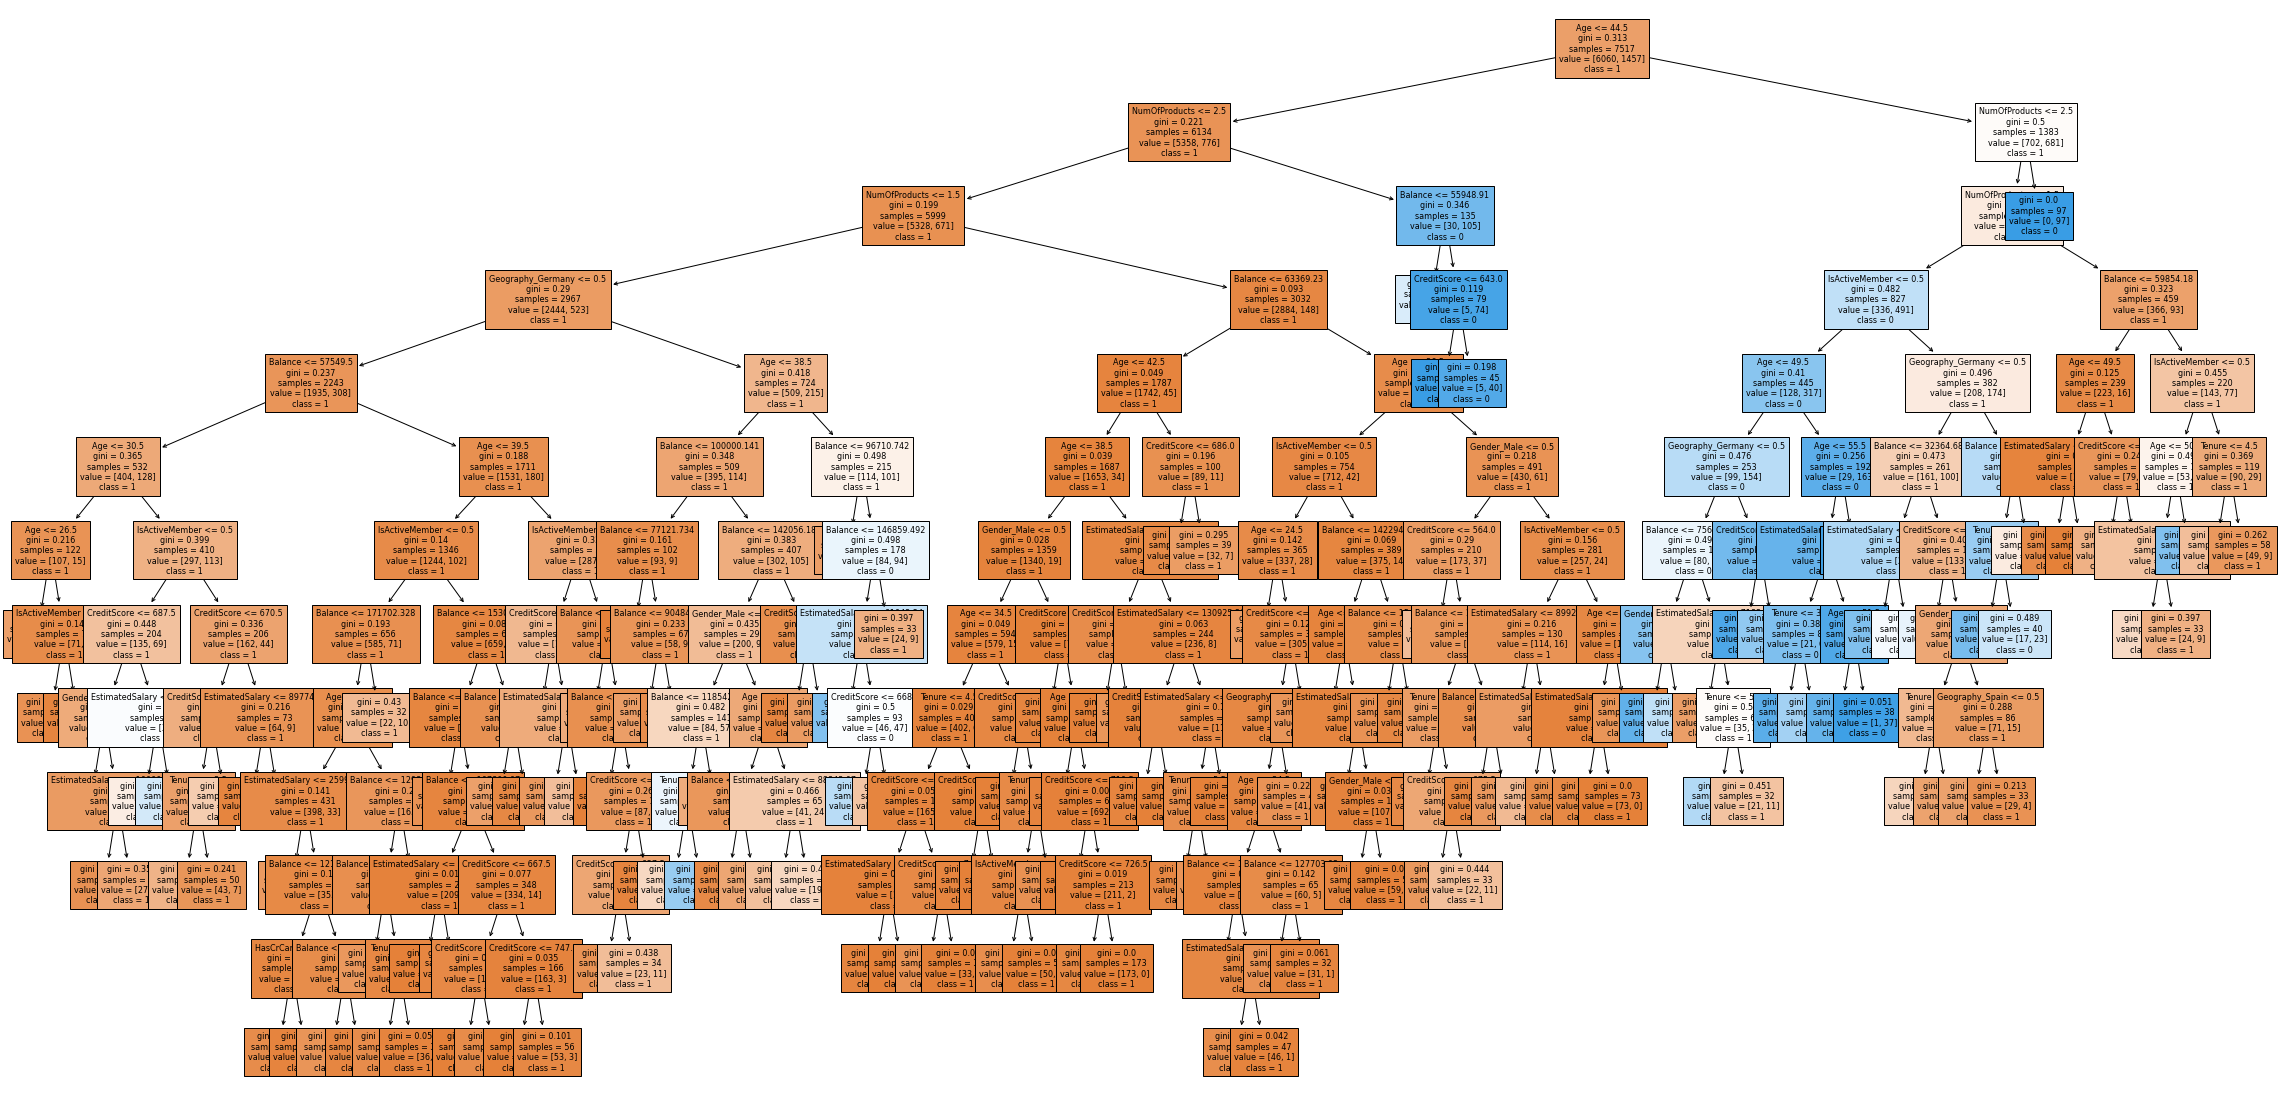

In [23]:
from sklearn import tree

# Since the 'GridSearchCV' object has no attribute 'tree_'
clf = DecisionTreeClassifier(max_depth = grid_search.best_params_['max_depth'], 
                             min_samples_leaf = grid_search.best_params_['min_samples_leaf'])
clf.fit(X_train, y_train)

# Visualisation of DT
fn = list(X.columns)
cn = [str(s) for s in y.unique()]

plt.subplots(figsize=(40, 20))
tree.plot_tree(clf, feature_names=fn, class_names=cn,
               filled=True, fontsize=8)

plt.show()

---
# 6. Random Forest
---

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
parameters = {'max_depth':[4,8,12,16,20,24,32],
              'min_samples_leaf':[1,2,4,8,12,16],
              'n_estimators':[10,25,50,75,100,250,500]}

In [ ]:
optimized parameters = {'max_depth': 32, 'min_samples_leaf': 2, 'n_estimators': 25}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(), parameters,
                           verbose=1, n_jobs=-1, scoring='f1')

In [ ]:
grid_search.fit(X_train, y_train)

In [25]:
# Save Model
#joblib.dump(grid_search, './models/RF.pkl')

# Load Model
grid_search = joblib.load('./models/RF.pkl')

In [26]:
grid_search.best_params_

{'max_depth': 32, 'min_samples_leaf': 2, 'n_estimators': 25}

In [27]:
rf_predicted = grid_search.predict(X_test)

In [28]:
confusion_matrix(y_test, rf_predicted)

array([[1447,   45],
       [ 217,  171]])

[ TN FP ]  
[ FN TP ]

TP (Predict as churn; the truth is churn)  
TN (Predict as not churn; the truth is not churn)  
FP (Predict as churn; the truth is not churn)  
FN (Predict as not churn; the truth is churn)

In [29]:
my_eval('RF',y_test, rf_predicted)

RF Results
Accuracy:  0.8606382978723405
F1 Score:  0.5662251655629138
Precision:  0.7916666666666666
Recall:  0.44072164948453607


,LR,KNN,SVM,NB,DT,RF
Accuracy,0.827660,0.830851,0.856383,0.841489,0.851064,0.860638
F1 Score,0.388679,0.475248,0.548495,0.460145,0.575758,0.566225
Precision,0.725352,0.660550,0.780952,0.774390,0.698529,0.791667
Recall,0.265464,0.371134,0.422680,0.327320,0.489691,0.440722


---
# 7. Performance Graph Comparison
---

In [30]:
df_model_compare.to_csv('./eval_results/eval_results_2.csv')

In [31]:
df_model_compare.index

Index(['Accuracy', 'F1 Score', 'Precision', 'Recall'], dtype='object')

In [32]:
%config InlineBackend.figure_format = 'retina'

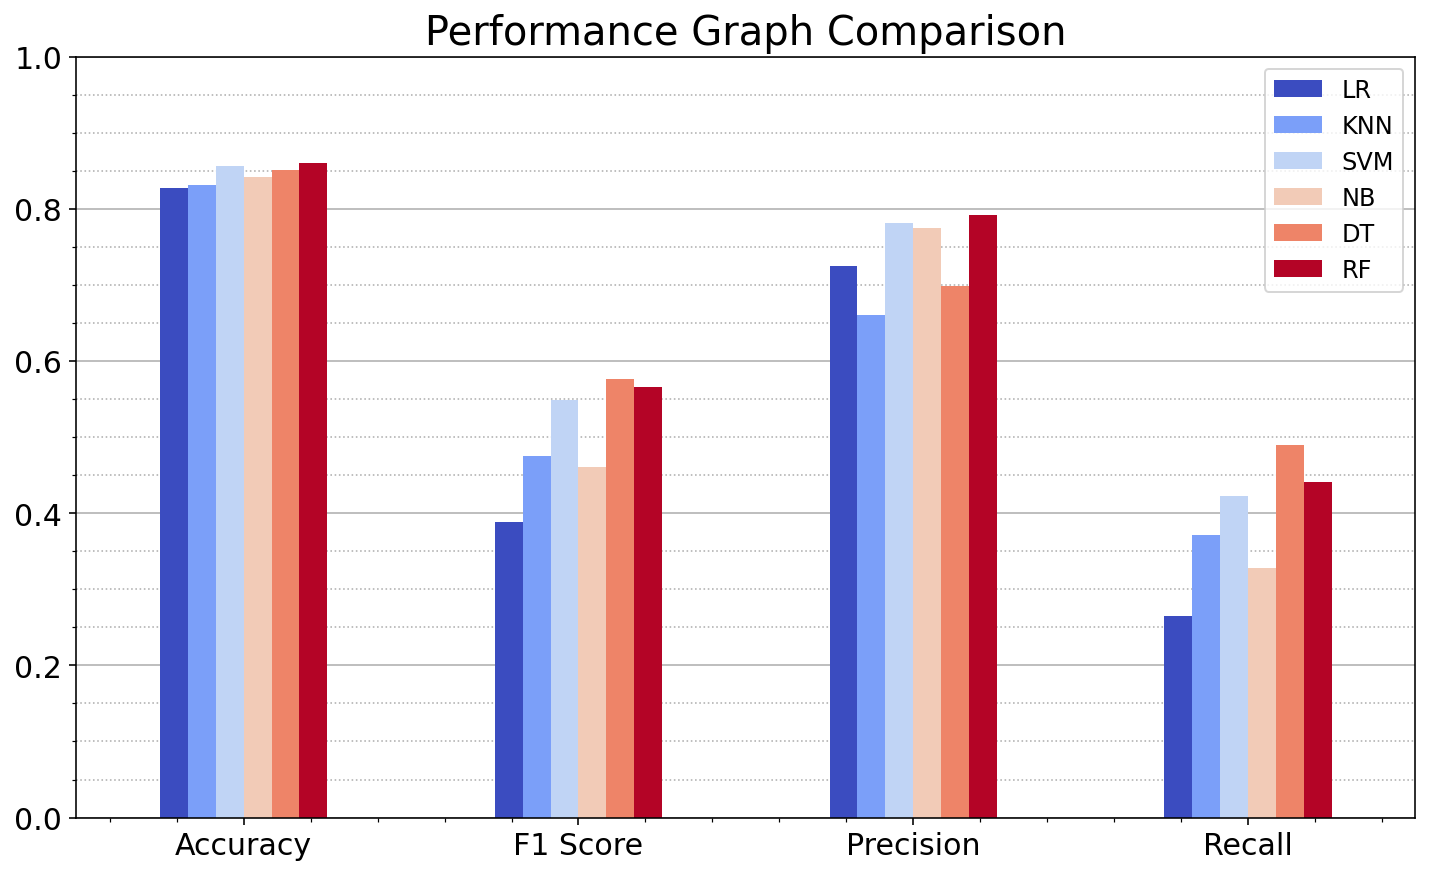

In [33]:
ax = df_model_compare.plot(
    kind='bar', cmap='coolwarm', rot=0,
    ylim=(0,1), figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12)

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.title('Performance Graph Comparison', fontsize=20)
plt.savefig('./img/graph')
plt.show()

---
# Thank You